In [1]:
import pandas as pd
from collections import Counter
import numpy as np

In [2]:


# === Step 1: Load the dataset ===
df = pd.read_csv("./00_data/indiana_reports.csv")  # Change the file path as needed

# === Step 2: Extract and clean the 'Problems' column ===
problem_series = df['Problems'].dropna()
problem_series = problem_series[problem_series.str.lower() != 'normal']

# Split entries on semicolons and clean whitespace
all_problems = problem_series.str.split(";").explode().str.strip()

# Extract the main term before any slashes (e.g., "Opacity/lung" → "Opacity")
main_terms = all_problems.str.split("/").str[0].str.strip()

# === Step 3: Count the frequency of each main term ===
problem_counts = Counter(main_terms)
problem_counts_df = pd.DataFrame(problem_counts.items(), columns=["Term", "Frequency"])
problem_counts_df = problem_counts_df.sort_values(by="Frequency", ascending=False).reset_index(drop=True)

# === Step 4: Define sets of known terms for each category ===
disease_keywords = {
    "Cardiomegaly", "Pulmonary Atelectasis", "Bullous Emphysema", "Pulmonary Fibrosis",
    "Pneumonia", "Tuberculosis", "Chronic Obstructive Pulmonary Disease", "COPD",
    "Emphysema", "Neoplasm", "Hernia", "Edema", "Infiltration", "Mass", "Nodule",
    "Consolidation", "Fibrosis", "Pleural Thickening", "Effusion", "Pleural Effusion","Pneumothorax","Pulmonary Edema",
    "Hernia, Hiatal","Infiltrate","Thickening","Calcified Granuloma","Granulomatous Disease","Airspace Disease"
}

structure_keywords = {
    "Lung", "Pulmonary Artery", "Thoracic Vertebrae", "Diaphragm", "Heart",
    "Rib", "Chest Wall", "Mediastinum", "Trachea", "Pleura"
}


# === Step 5: Classification function ===
def classify_term(term):
    if term in disease_keywords:
        return "Disease"
    elif term in structure_keywords:
        return "Anatomical Structure"
    else:
        return "Uncategorized"

# === Step 6: Apply classification ===
problem_counts_df["Category"] = problem_counts_df["Term"].apply(classify_term)

# === Step 7: Output the results ===
problem_counts_df.to_csv("problem_term_classified.csv", index=False)
print(problem_counts_df.head(20))  # View the top 20 terms by frequency


                     Term  Frequency              Category
0                    Lung        553  Anatomical Structure
1                 Opacity        509         Uncategorized
2            Cardiomegaly        345               Disease
3              Calcinosis        332         Uncategorized
4   Pulmonary Atelectasis        330               Disease
5     Calcified Granuloma        276               Disease
6      Thoracic Vertebrae        256  Anatomical Structure
7                Cicatrix        196         Uncategorized
8                   Spine        174         Uncategorized
9                Markings        167         Uncategorized
10       Pleural Effusion        160               Disease
11                  Aorta        158         Uncategorized
12              Diaphragm        140  Anatomical Structure
13                Density        129         Uncategorized
14        Atherosclerosis        125         Uncategorized
15              Deformity        124         Uncategoriz

In [3]:
problem_counts_df[problem_counts_df['Category']=='Disease']

,Term,Frequency,Category
2,Cardiomegaly,345,Disease
4,Pulmonary Atelectasis,330,Disease
5,Calcified Granuloma,276,Disease
10,Pleural Effusion,160,Disease
16,Airspace Disease,123,Disease
19,Nodule,116,Disease
20,Granulomatous Disease,107,Disease
31,Infiltrate,63,Disease
32,Emphysema,60,Disease
34,Thickening,53,Disease


In [4]:
problem_counts_df[problem_counts_df['Category']=='Disease'][['Frequency']].sum()

Frequency    1857
dtype: int64

In [5]:
problem_counts_df[problem_counts_df['Category']=='Disease']['Term']

2               Cardiomegaly
4      Pulmonary Atelectasis
5        Calcified Granuloma
10          Pleural Effusion
16          Airspace Disease
19                    Nodule
20     Granulomatous Disease
31                Infiltrate
32                 Emphysema
34                Thickening
37            Hernia, Hiatal
38           Pulmonary Edema
39                 Pneumonia
45             Consolidation
51              Pneumothorax
53        Pulmonary Fibrosis
56                      Mass
82         Bullous Emphysema
102             Tuberculosis
106                 Fibrosis
Name: Term, dtype: object

In [6]:
# === Step 8: Define final disease label list (14 ChestX-ray14 + 1 custom) ===
final_labels = [
    "Cardiomegaly", "Pulmonary Atelectasis", "Pleural Effusion", "Nodule",
    "Infiltrate", "Emphysema", "Thickening", "Hernia", "Pulmonary Edema",
    "Pneumonia", "Consolidation", "Pneumothorax", "Fibrosis", "Mass", "Granuloma"
]

# === Step 9: Define label mapping for normalization ===
label_mapping = {
    "Bullous Emphysema": "Emphysema",
    "Pulmonary Fibrosis": "Fibrosis",
    "Hernia, Hiatal": "Hernia",
    "Pulmonary Emphysema": "Emphysema",
    "Calcified Granuloma":"Granuloma",
    "Granulomatous Disease":"Granuloma",
    "Airspace Disease": "Consolidation",
}

# === Step 10: Extract disease labels from the Problems column ===
def extract_labels(problem_str):
    if pd.isna(problem_str) or problem_str.lower() == "normal":
        return ""  
    raw_terms = [term.strip().split("/")[0] for term in problem_str.split(";")]
    mapped = [label_mapping.get(term, term) for term in raw_terms]
    labels = set(label for label in mapped if label in final_labels)
    return ", ".join(labels) if labels else ""  

# Add new binary label columns based on extracted label sets
df["extracted_labels"] = df["Problems"].apply(extract_labels)

for label in final_labels:
    df[label] = df["extracted_labels"].apply(lambda labels: 1 if label in labels else 0)


In [7]:
df["Normal"] = np.where(df["Problems"].str.lower() == "normal", 1, 0)

In [8]:
df

,uid,MeSH,Problems,image,indication,comparison,findings,impression,extracted_labels,Cardiomegaly,...,Thickening,Hernia,Pulmonary Edema,Pneumonia,Consolidation,Pneumothorax,Fibrosis,Mass,Granuloma,Normal
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,,0,...,0,0,0,0,0,0,0,0,0,1
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.,Cardiomegaly,1,...,0,0,0,0,0,0,0,0,0,0
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p...",,0,...,0,0,0,0,0,0,0,0,0,1
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...,"Fibrosis, Emphysema",0,...,0,0,0,0,0,0,1,0,0,0
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.,Thickening,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3846,3995,Lung/hyperdistention/mild;Diaphragm/bilateral/...,Lung;Diaphragm;Cicatrix;Pulmonary Atelectasis;...,Xray Chest PA and Lateral,"Nausea, vomiting x2 weeks. Dialysis patient.","XXXX, XXXX.",The cardiomediastinal silhouette and pulmonary...,1. Interval resolution of bibasilar airspace d...,"Pulmonary Atelectasis, Emphysema",0,...,0,0,0,0,0,0,0,0,0,0
3847,3996,Spine/degenerative,Spine,Xray Chest PA and Lateral,NaN,None.,The lungs are clear. Heart size is normal. No ...,Clear lungs. No acute cardiopulmonary abnormal...,,0,...,0,0,0,0,0,0,0,0,0,0
3848,3997,Opacity/lung/upper lobe/right/round/small;Gran...,Opacity;Granuloma,PA and lateral views of the chest.,XXXX-year-old male with positive PPD.,None available.,"Heart size within normal limits. Small, nodula...","No acute findings, no evidence for active TB.",Granuloma,0,...,0,0,0,0,0,0,0,0,1,0
3849,3998,normal,normal,"PA and lateral chest XXXX, XXXX XXXX comparis...",tuberculosis positive PPD,NaN,NaN,Heart size is normal and the lungs are clear.,,0,...,0,0,0,0,0,0,0,0,0,1


In [9]:
# drop helper column
# df.drop(columns=["extracted_labels"], inplace=True)

# === Step 11: Save the annotated dataset ===
df.to_csv("./01_preprocess_data/indiana_reports_labeled.csv", index=False)
print("Multi-label dataset saved with 15 disease classes.")

Multi-label dataset saved with 15 disease classes.


In [9]:
# List of all label columns (15 diseases + Normal)
label_columns = [
    "Cardiomegaly", "Pulmonary Atelectasis", "Pleural Effusion", "Nodule",
    "Infiltrate", "Emphysema", "Thickening", "Hernia", "Pulmonary Edema",
    "Pneumonia", "Consolidation", "Pneumothorax", "Fibrosis", "Mass",
    "Granuloma", "Normal"
]

# Count how many rows have at least one label equal to 1
count_with_label = (df[label_columns].sum(axis=1) > 0).sum()

print(f"Number of samples with at least one label: {count_with_label}")

Number of samples with at least one label: 2697


In [10]:
# Select rows where all label columns are 0
unlabeled_df = df[df[label_columns].sum(axis=1) == 0]

# Output to CSV for inspection
unlabeled_df.to_csv("./01_preprocess_data/unlabeled_samples.csv", index=False)

print(f"{len(unlabeled_df)} unlabeled samples saved to 'unlabeled_samples.csv'.")

1154 unlabeled samples saved to 'unlabeled_samples.csv'.


In [11]:
# Count how many rows have more than 1 labels
count_with_labels = (df[label_columns].sum(axis=1) > 1).sum()
count_with_labels

np.int64(395)

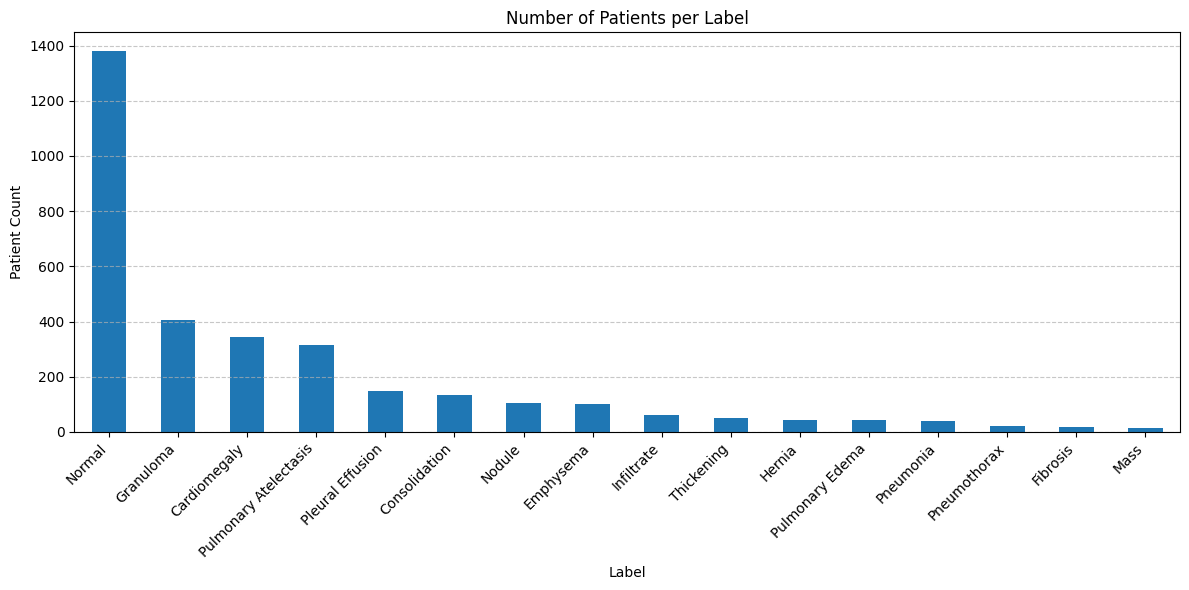

In [12]:
import matplotlib.pyplot as plt

# Count the number of patients (samples) with each label
label_counts = df[label_columns].sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar')
plt.title("Number of Patients per Label")
plt.ylabel("Patient Count")
plt.xlabel("Label")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [13]:
label_counts

Normal                   1379
Granuloma                 407
Cardiomegaly              345
Pulmonary Atelectasis     315
Pleural Effusion          149
Consolidation             134
Nodule                    106
Emphysema                 100
Infiltrate                 60
Thickening                 52
Hernia                     44
Pulmonary Edema            42
Pneumonia                  40
Pneumothorax               22
Fibrosis                   19
Mass                       15
dtype: int64